##One Pipepline, Many Classifiers
* Naive Bayes
* Logistic Regression
* Support Vector Machine


###Naive Bayes Classifier

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd # to work with csv files

# matplotlib imports are used to plot confusion matrices for the classifiers
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt

# import feature extraction methods from sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import _stop_words

# pre-processing of text
import string
import re

# import classifiers from sklearn
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

# import different metrics to evaluate the classifiers
from sklearn import metrics

# from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import metrics

# import time function from time module to track the training duration
from time import time

In [2]:
try:
    from google.colab import files
    !wget -P DATAPATH https://raw.githubusercontent.com/practical-nlp/practical-nlp/master/Ch4/Data/Full-Economic-News-DFE-839861.csv
    !ls -lah DATAPATH
    our_data = pd.read_csv("DATAPATH/Full-Economic-News-DFE-839861.csv" , encoding = "ISO-8859-1" )

except ModuleNotFoundError:
    our_data = pd.read_csv("Data/Full-Economic-News-DFE-839861.csv" , encoding = "ISO-8859-1" )

--2024-02-11 19:46:52--  https://raw.githubusercontent.com/practical-nlp/practical-nlp/master/Ch4/Data/Full-Economic-News-DFE-839861.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12383529 (12M) [text/plain]
Saving to: ‘DATAPATH/Full-Economic-News-DFE-839861.csv’

Full-Economic-News- 100%[===================>]  11.81M  --.-KB/s    in 0.1s    

2024-02-11 19:46:52 (114 MB/s) - ‘DATAPATH/Full-Economic-News-DFE-839861.csv’ saved [12383529/12383529]

total 12M
drwxr-xr-x 2 root root 4.0K Feb 11 19:46 .
drwxr-xr-x 1 root root 4.0K Feb 11 19:46 ..
-rw-r--r-- 1 root root  12M Feb 11 19:46 Full-Economic-News-DFE-839861.csv


**Section 1: Load and explore the dataset**

In [3]:
display(our_data.shape) # Number of rows (instances) and columns in the dataset
our_data["relevance"].value_counts()/our_data.shape[0] # Class distribution in the dataset

(8000, 15)

no          0.821375
yes         0.177500
not sure    0.001125
Name: relevance, dtype: float64

There is an imbalance in the data with not relevant being 82% in the dataset. That is, most of the articles are not relevant to US Economy, which makes sense in a real-world scenario, as news articles discuss various topics. We should keep this class imbalance mind when interpreting the classifier performance later. Let us first convert the class labels into binary outcome variables for convenience. 1 for Yes (relevant), and 0 for No (not relevant), and ignore "Not sure".

In [4]:
our_data.head()

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,positivity,positivity:confidence,relevance,relevance:confidence,articleid,date,headline,positivity_gold,relevance_gold,text
0,842613455,False,finalized,3,12/5/15 17:48,3.0,0.6400,yes,0.640,wsj_398217788,8/14/91,Yields on CDs Fell in the Latest Week,NaN,NaN,NEW YORK -- Yields on most certificates of dep...
1,842613456,False,finalized,3,12/5/15 16:54,NaN,NaN,no,1.000,wsj_399019502,8/21/07,The Morning Brief: White House Seeks to Limit ...,NaN,NaN,The Wall Street Journal Online</br></br>The Mo...
2,842613457,False,finalized,3,12/5/15 1:59,NaN,NaN,no,1.000,wsj_398284048,11/14/91,Banking Bill Negotiators Set Compromise --- Pl...,NaN,NaN,WASHINGTON -- In an effort to achieve banking ...
3,842613458,False,finalized,3,12/5/15 2:19,NaN,0.0000,no,0.675,wsj_397959018,6/16/86,Manager's Journal: Sniffing Out Drug Abusers I...,NaN,NaN,The statistics on the enormous costs of employ...
4,842613459,False,finalized,3,12/5/15 17:48,3.0,0.3257,yes,0.640,wsj_398838054,10/4/02,Currency Trading: Dollar Remains in Tight Rang...,NaN,NaN,NEW YORK -- Indecision marked the dollar's ton...


In [5]:
# convert label to a numerical variable
our_data = our_data[our_data.relevance != "not sure"] # removing the data where we don't want relevance="not sure".
our_data.shape
our_data['relevance'] = our_data.relevance.map({'yes':1, 'no':0}) # relevant is 1, not-relevant is 0.
our_data = our_data[["text","relevance"]] # Let us take only the two columns we need.
our_data.shape

(7991, 2)

In [6]:
our_data.head()

,text,relevance
0,NEW YORK -- Yields on most certificates of dep...,1
1,The Wall Street Journal Online</br></br>The Mo...,0
2,WASHINGTON -- In an effort to achieve banking ...,0
3,The statistics on the enormous costs of employ...,0
4,NEW YORK -- Indecision marked the dollar's ton...,1


**Section 2: Text Pre-processing** </br>
Typical steps involve tokenization, lower casing, removing, stop words, punctuation markers etc, and vectorization. Other processes such as stemming/lemmatization can also be performed. Here, we are performing the following steps: removing br tags, punctuation, numbers, and stopwords. While we are using sklearn's list of stopwords, there are several other stop word lists (e.g., from NLTK) or sometimes, custom stopword lists are needed depending on the task.

In [8]:
stopwords = _stop_words.ENGLISH_STOP_WORDS
def clean(doc): # doc is a string of text
    doc = doc.replace("</br>", " ") # This text contains a lot of <br/> tags.
    doc = "".join([char.lower() for char in doc if char not in string.punctuation and not char.isdigit()])
    doc = " ".join([token for token in doc.split() if token not in stopwords])
    # remove punctuation and numbers
    return doc

**Section 3: Modeling** </br>
Now we are ready for the modelling. We are going to use algorithms from sklearn package. We will go through the following steps:

1. Split the data into training and test sets (75% train, 25% test)
2. Extract features from the training data using CountVectorizer, which is a bag of words feature implementation. We will use the pre-processing function above in conjunction with Count Vectorizer
3. Transform the test data into the same feature vector as the training data.
4. Train the classifier
5. Evaluate the classifier

In [9]:
import sklearn
#from sklearn.cross_validation import train_test_split
from sklearn.model_selection import train_test_split

# Step 1: train-test split
X = our_data['text'] # the column text contains textual data to extract features from
y = our_data['relevance'] # this is the column we are learning to predict.
print(X.shape, y.shape)
# split X and y into training and testing sets. By default, it splits 75% training and 25% test
# random_state=1 for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(7991,) (7991,)
(5993,) (5993,)
(1998,) (1998,)


In [10]:
# Step 2-3: Preprocess and Vectorize train and test data
vect = CountVectorizer(preprocessor=clean) # instantiate a vectoriezer
X_train_dtm = vect.fit_transform(X_train)# use it to extract features from training data
# transform testing data (using training data's features)
X_test_dtm = vect.transform(X_test)
print(X_train_dtm.shape, X_test_dtm.shape)
# i.e., the dimension of our feature vector is 49753!

(5993, 43424) (1998, 43424)


In [11]:
# Step 3: Train the classifier and predict for test data
nb = MultinomialNB() # instantiate a Multinomial Naive Bayes model
%time nb.fit(X_train_dtm, y_train) # train the model(timing it with an IPython "magic command")
y_pred_class = nb.predict(X_test_dtm) # make class predictions for X_test_dtm

CPU times: user 12.7 ms, sys: 0 ns, total: 12.7 ms
Wall time: 16.2 ms


Accuracy:  0.7762762762762763
Recall: 0.45321637426900585
F1 score: 0.4095112285336856


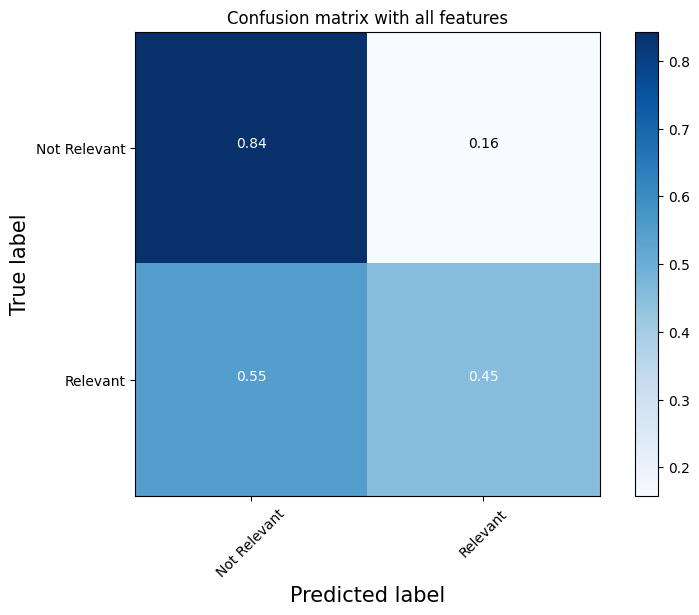

In [12]:
# Step 4: Evaluate the classifier using various measures

# Function to plot confusion matrix.
# Ref:http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
import itertools
from sklearn.metrics import roc_auc_score

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label',fontsize=15)
    plt.xlabel('Predicted label',fontsize=15)


# Print accuracy:
print("Accuracy: ", metrics.accuracy_score(y_test, y_pred_class))
print("Recall:",metrics.recall_score(y_test, y_pred_class))
print("F1 score:",metrics.f1_score(y_test, y_pred_class))

# print the confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred_class)
plt.figure(figsize=(8,6))
plot_confusion_matrix(cnf_matrix, classes=['Not Relevant','Relevant'],normalize=True,
                      title='Confusion matrix with all features')

At this point, we can notice that the classifier is doing poorly with identifying relevant articles, while it is doing well with non-relevant ones. Our large feature vector could be creating a lot of noise in the form of very rarely occurring features that are not useful for learning. Let us change the count vectorizer to take a certain number of features as maximum.

CPU times: user 5.12 ms, sys: 0 ns, total: 5.12 ms
Wall time: 5.14 ms
Accuracy:  0.6906906906906907
Recall: 0.6549707602339181
F1 score: 0.42026266416510316


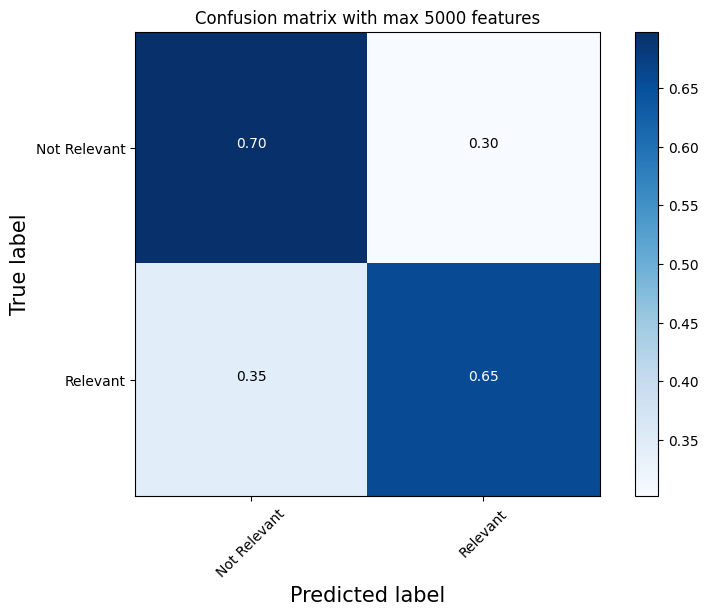

In [13]:
vect = CountVectorizer(preprocessor=clean, max_features=5000) # Step-1
X_train_dtm = vect.fit_transform(X_train) # combined step 2 and 3
X_test_dtm = vect.transform(X_test)
nb = MultinomialNB() # instantiate a Multinomial Naive Bayes model
%time nb.fit(X_train_dtm, y_train) # train the model(timing it with an IPython "magic command")
y_pred_class = nb.predict(X_test_dtm) # make class predictions for X_test_dtm
print("Accuracy: ", metrics.accuracy_score(y_test, y_pred_class))
print("Recall:",metrics.recall_score(y_test, y_pred_class))
print("F1 score:",metrics.f1_score(y_test, y_pred_class))
# print the confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred_class)
plt.figure(figsize=(8,6))
plot_confusion_matrix(cnf_matrix, classes=['Not Relevant','Relevant'],normalize=True,
                      title='Confusion matrix with max 5000 features')

Clearly, the performance on relevance classification got better even though the overall accuracy fell by 10%. Let us try another classification algorithm and see if the performance changes. For this experiment, we have considered logistic regression, with class_weight attribute as "balanced", to address the problem of class imbalance in this dataset.

###Logistic Regression Classifier

Accuracy:  0.7372372372372372
Recall: 0.34210526315789475
F1 score: 0.308300395256917


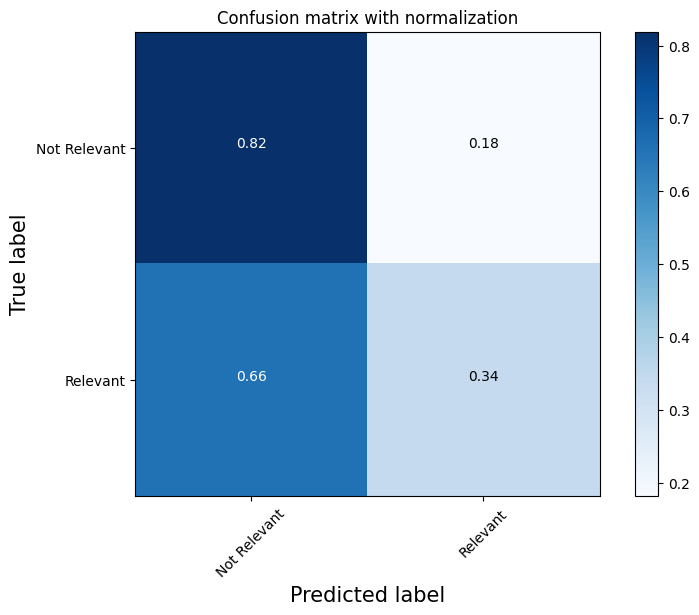

In [15]:
from sklearn.linear_model import LogisticRegression # import

logreg = LogisticRegression(class_weight="balanced") # instantiate a logistic regression model
logreg.fit(X_train_dtm, y_train) # fit the model with training data

# Make predictions on test data
y_pred_class = logreg.predict(X_test_dtm)

# calculate evaluation measures:
print("Accuracy: ", metrics.accuracy_score(y_test, y_pred_class))
print("Recall:",metrics.recall_score(y_test, y_pred_class))
print("F1 score:",metrics.f1_score(y_test, y_pred_class))
cnf_matrix = confusion_matrix(y_test, y_pred_class)
plt.figure(figsize=(8,6))
plot_confusion_matrix(cnf_matrix, classes=['Not Relevant','Relevant'],normalize=True,
                      title='Confusion matrix with normalization')

Let us wrap this notebook by trying with one more classifier, but reducing the feature vector size to 1000.

###Support Vector Machine

Accuracy:  0.6801801801801802
Recall: 0.5029239766081871
F1 score: 0.34994913530010174


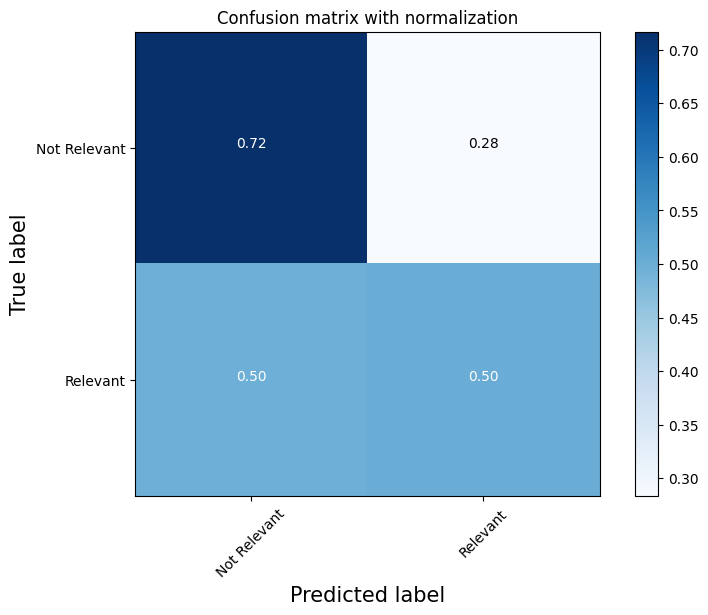

In [16]:
from sklearn.svm import LinearSVC

vect = CountVectorizer(preprocessor=clean, max_features=1000) # Step-1
X_train_dtm = vect.fit_transform(X_train) # combined step 2 and 3
X_test_dtm = vect.transform(X_test)

classifier = LinearSVC(class_weight='balanced') # instantiate a logistic regression model
classifier.fit(X_train_dtm, y_train) # fit the model with training data

# Make predictions on test data
y_pred_class = classifier.predict(X_test_dtm)

# calculate evaluation measures:
print("Accuracy: ", metrics.accuracy_score(y_test, y_pred_class))
print("Recall:",metrics.recall_score(y_test, y_pred_class))
print("F1 score:",metrics.f1_score(y_test, y_pred_class))
cnf_matrix = confusion_matrix(y_test, y_pred_class)
plt.figure(figsize=(8,6))
plot_confusion_matrix(cnf_matrix, classes=['Not Relevant','Relevant'],normalize=True,
                      title='Confusion matrix with normalization')

So, how do we choose whats the best? If we look at overall accuracy alone, we should be choosing the very first classifier in this notebook. However, that is also doing poorly with identifying "relevant" articles. If we choose purely based on how good it is doing with "relevant" category, we should choose the second one we built. If we choose purely based on how good it is doing with "irrelevant" category, surely, nothing beats not building any classifier and just calling everything irrelevant! So, what to choose as the best among these depends on what we are looking for in our use case!